In [42]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.applications import ResNet50,VGG16
from keras_resnet.models import ResNet18
from tensorflow.keras import layers, models
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten


In [ ]:
image_size = 32
batch_size = 4 

Функция для загрузки данных. Проходит по всем папкам в директории, где каждая папка представляет отдельный класс (кошки или собаки).  
Загружает изображения, ресайзит их до 32x32 и нормализует.  
Возвращает массивы изображений (images) и меток (labels).  

In [44]:
def load_data(directory, image_size):
    images = []
    labels = []
    for idx, label_dir in enumerate(os.listdir(directory)):
        if os.path.isdir(os.path.join(directory, label_dir)):
            label = idx #назначаем метку (0 — первая папка, 1 — вторая папка)
            for img in os.listdir(os.path.join(directory, label_dir)):
                img_path = os.path.join(directory, label_dir, img)
                if os.path.isfile(img_path):
                    image = tf.io.read_file(img_path)
                    image = tf.image.decode_jpeg(image, channels=3)
                    image = tf.image.resize(image, [image_size, image_size])
                    image /= 255.0
                    images.append(image)
                    labels.append(label)
    return np.array(images), np.array(labels)


In [45]:
images, labels = load_data(r"data\dogs_cats", image_size=image_size)


(array([1106.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2105.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

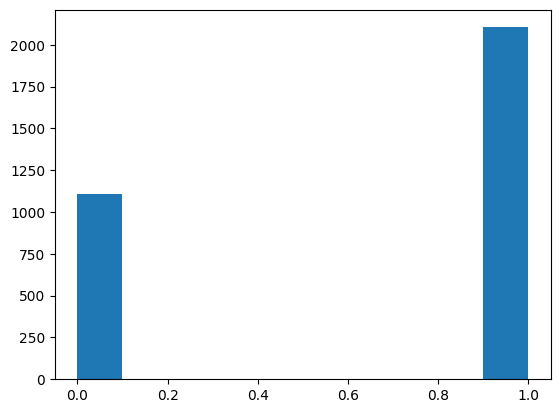

In [46]:
plt.hist(labels) 

Разделяем данные для обучения (80%) и тестирования (20%).  
Создаем датасеты и перемешиваем данные.  

In [47]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)


In [48]:
del images
del labels

Тестовый набор данных

In [49]:
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

Используем модель VGG16 и настраиваем.

In [ ]:
from keras_resnet.models import ResNet18
from tensorflow.keras.layers import Input

def create_model():
    inputs = Input(shape=(image_size, image_size, 3))
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  #бинарная классификация
                  metrics=['accuracy'])
    return model



Обучение модели, считаем f1-метрику.

In [54]:
def train_and_evaluate(train_images, train_labels, test_ds, epochs=10):
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(train_images)).batch(batch_size)
    model = create_model()
    model.fit(train_ds, epochs=2, validation_data=test_ds)
    y_pred = model.predict(test_images)
    y_pred_classes = (y_pred > 0.5).astype(int)
    return f1_score(test_labels, y_pred_classes, average='macro')

In [ ]:

#обучение на всем обучающем наборе
f1_full = train_and_evaluate(train_images, train_labels, test_ds)
print(f"F1-метрика (весь набор данных): {f1_full:.4f}")

#обучение на 1%, 10%, 20% обучающего набора
percentages = [0.01, 0.1, 0.2]
results = {p: [] for p in percentages}

for p in percentages:
    for _ in range(5):  
        sample_size = int(len(train_images) * p)
        indices = random.sample(range(len(train_images)), sample_size)
        train_images_sample = train_images[indices]
        train_labels_sample = train_labels[indices]

        #обучение и оценка
        f1 = train_and_evaluate(train_images_sample, train_labels_sample, test_ds)
        results[p].append(f1)

for p, scores in results.items():
    mean_f1 = np.mean(scores)
    print(f"F1-метрика ({int(p * 100)}% данных, средняя): {mean_f1:.4f}")


Epoch 1/2
642/642 ━━━━━━━━━━━━━━━━━━━━ 193s 294ms/step - accuracy: 0.6022 - loss: 0.7222 - val_accuracy: 0.6563 - val_loss: 0.6565
Epoch 2/2
642/642 ━━━━━━━━━━━━━━━━━━━━ 189s 295ms/step - accuracy: 0.6488 - loss: 0.6523 - val_accuracy: 0.6563 - val_loss: 0.6435
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step
F1-метрика (весь набор данных): 0.3962
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6263 - loss: 1.5607 - val_accuracy: 0.6563 - val_loss: 0.8217
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5859 - loss: 0.8388 - val_accuracy: 0.6563 - val_loss: 0.6765
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3792 - loss: 11.2904 - val_accuracy: 0.6563 - val_loss: 0.7732
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6668 - loss: 0.7324 - val_accuracy: 0.3437 - val_loss: 1.1251
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5407 - loss: 5.1003 - 

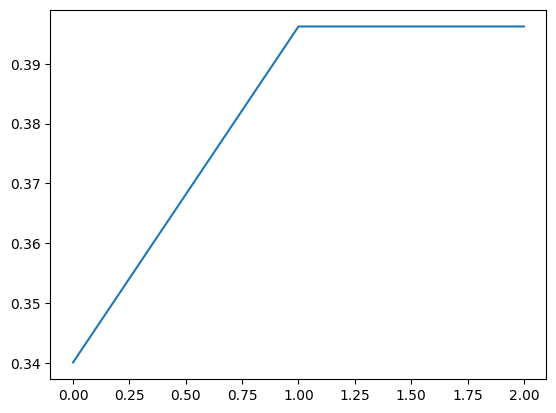

In [60]:
import matplotlib.pyplot as plt
plt.plot([np.mean(x) for x  in results.values()])

In [ ]:
from sklearn.cluster import KMeans

# 1. Least Confidence (LC)
def least_confidence_selection(model, unlabeled_data, n_samples):
    """Отбор наиболее неопределенных данных на основе наименьшей уверенности."""
    predictions = model.predict(unlabeled_data)
    uncertainties = 1 - np.max(predictions, axis=1)  
    uncertain_indices = np.argsort(uncertainties)[-n_samples:]  
    return uncertain_indices

# 2. Cluster Margin
def cluster_margin_selection(embeddings, n_samples):
    """Отбор данных на основе кластерного анализа."""
    kmeans = KMeans(n_clusters=n_samples, random_state=42)
    kmeans.fit(embeddings)
    closest_indices = []
    for center in kmeans.cluster_centers_:
        distances = np.linalg.norm(embeddings - center, axis=1)
        closest_indices.append(np.argmin(distances))
    return closest_indices

# 3. MNLP
def mnlp_selection(model, unlabeled_data, n_samples):
    predictions = model.predict(unlabeled_data)
    log_probs = np.log(predictions + 1e-10)
    normalized_log_probs = log_probs / np.linalg.norm(log_probs, axis=1, keepdims=True)
    scores = np.sum(normalized_log_probs, axis=1)
    mnlp_indices = np.argsort(scores)[-n_samples:]
    return mnlp_indices

# 4. Bald
def bald_selection(model, unlabeled_data, n_samples, num_mc_samples=10):
    f_model = tf.keras.models.Model(inputs=model.input, outputs=model.output)
    f_model.trainable = False

    mc_predictions = np.stack([
        f_model.predict(unlabeled_data, batch_size=batch_size, verbose=0)
        for _ in range(num_mc_samples)
    ])

    mean_prob = mc_predictions.mean(axis=0)
    entropy = -np.sum(mean_prob * np.log(mean_prob + 1e-10), axis=1)

    mc_entropy = -np.sum(mc_predictions * np.log(mc_predictions + 1e-10), axis=2)
    mean_mc_entropy = mc_entropy.mean(axis=0)
    bald_score = entropy - mean_mc_entropy  

    bald_indices = np.argsort(bald_score)[-n_samples:]
    return bald_indices


In [ ]:
#новый блок для активного обучения
active_learning_results = {p: {"LC": [], "ClusterMargin": [], "BALD": [], "MNLP": []} for p in percentages}

for p in percentages:
    for _ in range(5):  
        sample_size = int(len(train_images) * p)
        unlabeled_data = train_images.copy()

        #создаем новую модель для каждой итерации
        model = create_model()

        # Least Confidence
        lc_indices = least_confidence_selection(model, unlabeled_data, sample_size)
        lc_images = unlabeled_data[lc_indices]
        lc_labels = train_labels[lc_indices]
        f1_lc = train_and_evaluate(lc_images, lc_labels, test_ds)
        active_learning_results[p]["LC"].append(f1_lc)

        # Cluster Margin
        embeddings_model = models.Model(inputs=model.input, outputs=model.layers[-2].output)
        embeddings = embeddings_model.predict(unlabeled_data)
        cm_indices = cluster_margin_selection(embeddings, sample_size)
        cm_images = unlabeled_data[cm_indices]
        cm_labels = train_labels[cm_indices]
        f1_cm = train_and_evaluate(cm_images, cm_labels, test_ds)
        active_learning_results[p]["ClusterMargin"].append(f1_cm)

        # BALD
        bald_indices = bald_selection(model, unlabeled_data, sample_size)
        bald_images = unlabeled_data[bald_indices]
        bald_labels = train_labels[bald_indices]
        f1_bald = train_and_evaluate(bald_images, bald_labels, test_ds)
        active_learning_results[p]["BALD"].append(f1_bald)

        # Maximum Normalized Log-Probability
        mnlp_indices = mnlp_selection(model, unlabeled_data, sample_size)
        mnlp_images = unlabeled_data[mnlp_indices]
        mnlp_labels = train_labels[mnlp_indices]
        f1_mnlp = train_and_evaluate(mnlp_images, mnlp_labels, test_ds)
        active_learning_results[p]["MNLP"].append(f1_mnlp)

#вывод результатов
for p, strategies in active_learning_results.items():
    for strategy_name, scores in strategies.items():
        mean_f1 = np.mean(scores)
        print(f"F1-метрика ({int(p * 100)}% данных, {strategy_name}, средняя): {mean_f1:.4f}")

#визуализация
for strategy_name in ["LC", "ClusterMargin", "BALD", "MNLP"]:
    plt.plot([np.mean(active_learning_results[p][strategy_name]) for p in percentages], label=strategy_name)

plt.xlabel("Процент данных")
plt.ylabel("Средняя F1-метрика")
plt.legend()
plt.show()


81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step
Epoch 1/2


AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/functional_30_1/block5_conv3_1/convolution/Conv2DBackpropFilter defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/functional_30_1/block5_conv3_1/convolution/Conv2DBackpropFilter}}]] [Op:__inference_multi_step_on_iterator_360894]